# Transfer Learning Hypothesis Validation with AlexNet for Pneumonia Classification
 This notebook implements and compares two binary classifiers for pneumonia detection:
 - Classifier A: Direct training on raw X-ray images using a simple MLP
 - Classifier B: Training with AlexNet pre-trained embeddings using the same MLP architecture

## Initial Setup and Dependencies Installation
 Install and import all required packages for PyTorch neural networks, data handling, 
 visualization, and scientific computing. We'll use PyTorch for deep learning models,
 torchvision for pre-trained AlexNet and image transformations, and matplotlib for plotting.

In [24]:


## Initial Setup and Dependencies
# Install required packages for PyTorch and neural network implementation
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchvision.models as models
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns



## Dataset Loading and Preprocessing Configuration
 Configure data transformations for both classification approaches. The key difference is that
 Classifier A will work with raw grayscale images (50,176 features = 224x224x1), while 
 Classifier B will use AlexNet's ImageNet-pretrained features. We need different preprocessing
 for each approach to match their respective input requirements.

 Define the path the local pneumonia dataset

In [ ]:
# Define the path to the local pneumonia dataset
dataset_path = 'data/chest_xray/chest_xray/train'

# Transformations for Classifier A (Direct MLP approach)
# Process X-ray images to grayscale 224x224 format for direct pixel-based classification
# This maintains the medical imaging characteristics while standardizing input size
transform_direct = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),                # Resize to AlexNet input dimensions for comparison
    transforms.ToTensor(),                        # Convert PIL Image to tensor [0,1] range
])

Transformations for Classifier B (Transfer Learning with AlexNet)
 Process images to match ImageNet preprocessing used during AlexNet's original training
 This ensures optimal feature extraction from the pre-trained network

In [26]:

transform_alexnet = transforms.Compose([
    transforms.Resize((224, 224)),                # Standard AlexNet input size
    transforms.ToTensor(),                        # Convert to tensor format
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

## Dataset Loading and Data Loader Creation
 Create PyTorch datasets and data loaders for both classification approaches.
 We use the same train/test split for both classifiers to ensure fair comparison.
 The batch size of 32 provides a good balance between memory usage and training stability.

In [27]:
# Load datasets for direct classification (Classifier A)
train_dataset_direct = ImageFolder(root=f'{dataset_path}/train', transform=transform_direct)
test_dataset_direct = ImageFolder(root=f'{dataset_path}/test', transform=transform_direct)

# Load datasets for transfer learning (Classifier B)  
train_dataset_alexnet = ImageFolder(root=f'{dataset_path}/train', transform=transform_alexnet)
test_dataset_alexnet = ImageFolder(root=f'{dataset_path}/test', transform=transform_alexnet)

# Create data loaders with consistent batch size for both approaches
batch_size = 32
train_loader_direct = DataLoader(train_dataset_direct, batch_size=batch_size, shuffle=True)
test_loader_direct = DataLoader(test_dataset_direct, batch_size=batch_size, shuffle=False)
train_loader_alexnet = DataLoader(train_dataset_alexnet, batch_size=batch_size, shuffle=True)
test_loader_alexnet = DataLoader(test_dataset_alexnet, batch_size=batch_size, shuffle=False)

# Display dataset information for verification
print(f"Training samples: {len(train_dataset_direct)}")
print(f"Test samples: {len(test_dataset_direct)}")
print(f"Classes: {train_dataset_direct.classes}")


Training samples: 5216
Test samples: 624
Classes: ['NORMAL', 'PNEUMONIA']


## Simple MLP Architecture Definition
 Define a simple Multi-Layer Perceptron with one hidden layer for binary classification.
 This architecture will be used for both classifiers to ensure fair comparison.
 The only difference will be the input dimension (50,176 for raw images vs 4,096 for AlexNet features).

In [28]:

class SimpleMLP(nn.Module):
    """
    Simple MLP for binary classification with one hidden layer.
    
    Args:
        input_dim: Number of input features (50,176 for raw images, 4,096 for AlexNet features)
        hidden_dim: Number of neurons in hidden layer (default: 256)
        num_classes: Number of output classes (2 for binary classification)
    """
    def __init__(self, input_dim, hidden_dim=256, num_classes=2):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)    # Input to hidden layer
        self.fc2 = nn.Linear(hidden_dim, num_classes)  # Hidden to output layer
        
    def forward(self, x):
        x = F.relu(self.fc1(x))  # ReLU activation for hidden layer
        x = self.fc2(x)          # Linear output (logits)
        return x

## Utility Functions for Data Processing and Model Training
 Define helper functions for flattening images and training the MLP model.
 These functions will be reused for both classification approaches.

In [29]:
def flatten_images(data_loader):
    """
    Convert images from DataLoader to flattened vectors for MLP input.
    This function processes all batches and returns numpy arrays suitable for training.
    
    Args:
        data_loader: PyTorch DataLoader containing images and labels
        
    Returns:
        tuple: (X, y) where X is flattened images array and y is labels array
    """
    X = []
    y = []
    
    
    for batch_idx, (images, labels) in enumerate(data_loader):
        # Flatten images: (batch_size, channels, height, width) -> (batch_size, -1)
        images_flat = images.view(images.size(0), -1)
        X.append(images_flat)
        y.append(labels)
        
        if batch_idx % 20 == 0:
            print(f"Processed {batch_idx * data_loader.batch_size} images...")
    
    # Concatenate all batches into single arrays
    X_tensor = torch.cat(X, dim=0).numpy()
    y_tensor = torch.cat(y, dim=0).numpy()
    
    print(f"Final shape: X={X_tensor.shape}, y={y_tensor.shape}")
    return X_tensor, y_tensor

def train_mlp(X_train, y_train, X_test, y_test, input_dim, epochs=50, lr=1e-3, hidden_dim=256):
    """
    Train a Simple MLP model and track training progress.
    This function handles the complete training loop with progress monitoring.
    
    Args:
        X_train, y_train: Training data and labels
        X_test, y_test: Test data and labels  
        input_dim: Number of input features
        epochs: Number of training epochs
        lr: Learning rate for Adam optimizer
        hidden_dim: Number of hidden layer neurons
        
    Returns:
        tuple: (model, test_accuracy, training_time, training_history)
    """
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    
    # Initialize model, loss function, and optimizer
    model = SimpleMLP(input_dim=input_dim, hidden_dim=hidden_dim, num_classes=2)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Training history for plotting curves
    train_losses = []
    train_accuracies = []
    
    print(f"Starting training with {input_dim} input features...")
    start_time = time.time()
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Calculate training accuracy
        _, preds = torch.max(outputs, 1)
        train_acc = (preds == y_train_tensor).float().mean().item()
        
        # Store training history
        train_losses.append(loss.item())
        train_accuracies.append(train_acc)
        
        # Print progress every 10 epochs
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] - Loss: {loss.item():.4f}, Train Accuracy: {train_acc:.4f}")
    
    training_time = time.time() - start_time
    
    # Final evaluation on test set
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        _, test_preds = torch.max(test_outputs, 1)
        test_accuracy = (test_preds == y_test_tensor).float().mean().item()
    
    print(f"Training completed")
    print(f"Final Test Accuracy: {test_accuracy:.4f}")
    print(f"Training Time: {training_time:.2f} seconds")
    
    return model, test_accuracy, training_time, {'losses': train_losses, 'accuracies': train_accuracies}


## CLASSIFIER A: Direct MLP Training on Raw X-ray Images
 Train an MLP directly on flattened grayscale X-ray images. This approach uses the raw pixel values
 as features (224×224 = 50,176 features per image). The model must learn to recognize pneumonia
 patterns from scratch without any prior knowledge about medical imaging or general image features.
 This serves as our baseline approach to compare against transfer learning.

In [30]:
print("CLASSIFIER A: DIRECT MLP TRAINING ON RAW X-RAY IMAGES")

# Flatten images for direct MLP input
X_train_direct, y_train_direct = flatten_images(train_loader_direct)
X_test_direct, y_test_direct = flatten_images(test_loader_direct)

print(f"\nClassifier A Data Preparation Complete:")
print(f" Training data shape: {X_train_direct.shape}")
print(f" Test data shape: {X_test_direct.shape}")
print(f" Features per image: {X_train_direct.shape[1]:,}")
print(f" Memory usage: ~{X_train_direct.nbytes / (1024**2):.1f} MB for training data")

# Train Classifier A
print(f"\nTraining Simple MLP on raw image pixels")
print(f"Architecture: {X_train_direct.shape[1]} → 256 → 2")

model_a, accuracy_a, train_time_a, history_a = train_mlp(
    X_train_direct, y_train_direct, 
    X_test_direct, y_test_direct, 
    input_dim=X_train_direct.shape[1],
    epochs=50,
    lr=0.001
)


print(f"CLASSIFIER A RESULTS:")

print(f"Test Accuracy: {accuracy_a:.4f} ({accuracy_a*100:.2f}%)")
print(f"Training Time: {train_time_a:.2f} seconds")
print(f"Convergence: {len(history_a['losses'])} epochs")

CLASSIFIER A: DIRECT MLP TRAINING ON RAW X-RAY IMAGES
Processed 0 images...
Processed 640 images...
Processed 1280 images...
Processed 1920 images...
Processed 2560 images...
Processed 3200 images...
Processed 3840 images...
Processed 4480 images...
Processed 5120 images...
Final shape: X=(5216, 50176), y=(5216,)
Processed 0 images...
Final shape: X=(624, 50176), y=(624,)

Classifier A Data Preparation Complete:
 Training data shape: (5216, 50176)
 Test data shape: (624, 50176)
 Features per image: 50,176
 Memory usage: ~998.4 MB for training data

Training Simple MLP on raw image pixels
Architecture: 50176 → 256 → 2
Starting training with 50176 input features...
Epoch [10/50] - Loss: 6.1674, Train Accuracy: 0.7429
Epoch [20/50] - Loss: 0.8505, Train Accuracy: 0.7446
Epoch [30/50] - Loss: 0.3219, Train Accuracy: 0.8554
Epoch [40/50] - Loss: 0.3634, Train Accuracy: 0.8365
Epoch [50/50] - Loss: 0.3126, Train Accuracy: 0.8616
Training completed
Final Test Accuracy: 0.8173
Training Time: 9

The output shows successful data preprocessing with the correct dimensionality. We observe 5,216 training samples, each represented by 50,176 features (224×224×1), confirming proper grayscale image flattening. The memory footprint of nearly 1GB indicates the substantial computational requirements for storing raw pixel data.

The training trajectory reveals a model learning effectively from scratch. The dramatic loss reduction from 6.17 to 0.31 demonstrates successful optimization. However, the slight accuracy fluctuation between epochs 30-40 (85.54% → 83.65%) suggests some instability in the learning process, typical when training on high-dimensional raw pixel data.

The model achieves a respectable 81.73% test accuracy, demonstrating that direct pixel-based learning is feasible for this pneumonia classification task. The training time of 99.42 seconds reflects the computational burden of processing 50,176-dimensional input vectors.

## AlexNet Feature Extraction Setup
 Load pre-trained AlexNet and modify it for feature extraction. We remove the final classification
 layer to obtain 4,096-dimensional feature embeddings. These embeddings represent high-level
 features learned from millions of natural images, which we hypothesize will transfer well to
 medical X-ray analysis despite the domain difference.

In [31]:
print("ALEXNET FEATURE EXTRACTION SETUP")

print("We'll use its learned feature representations for medical image analysis.")

# Load pre-trained AlexNet and remove final classification layer
alexnet = models.alexnet(pretrained=True)
print(f"Original AlexNet classifier: {alexnet.classifier}")

# Remove the last layer (Linear(4096, 1000)) to get 4,096-dimensional embeddings
alexnet.classifier = nn.Sequential(*list(alexnet.classifier.children())[:-1])
print(f"Modified AlexNet classifier: {alexnet.classifier}")

# Set to evaluation mode for feature extraction
alexnet.eval()

def extract_embeddings(data_loader, model, description=""):
    """
    Extract feature embeddings using pre-trained AlexNet model.
    This process converts raw images to high-level feature representations.
    
    Args:
        data_loader: PyTorch DataLoader with preprocessed images
        model: Pre-trained AlexNet model (without final classification layer)
        description: String description for progress printing
        
    Returns:
        tuple: (embeddings, labels) as numpy arrays
    """
    embeddings = []
    labels = []
    
    print(f"Extracting embeddings {description}...")
    
    with torch.no_grad():  # Disable gradient computation for efficiency
        for batch_idx, (images, label) in enumerate(data_loader):
            # Extract features using AlexNet
            outputs = model(images)
            embeddings.append(outputs)
            labels.append(label)
            
            if batch_idx % 20 == 0:
                print(f"Processed {batch_idx * data_loader.batch_size} images")
    
    # Concatenate all batches
    embeddings_array = torch.cat(embeddings).numpy()
    labels_array = torch.cat(labels).numpy()
    
    print(f"Embeddings extracted: {embeddings_array.shape}")
    return embeddings_array, labels_array


ALEXNET FEATURE EXTRACTION SETUP
We'll use its learned feature representations for medical image analysis.


c:\Users\Lenovo\Documents\JU\Ciencia datos\csds-352-machine-learning-vault\csds-352-machine-learning-vault\venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Lenovo\Documents\JU\Ciencia datos\csds-352-machine-learning-vault\csds-352-machine-learning-vault\venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Original AlexNet classifier: Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)
Modified AlexNet classifier: Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
)


The output confirms successful removal of the final classification layer (1000-class ImageNet classifier), leaving us with 4,096-dimensional feature embeddings. The architecture modification preserves all feature extraction layers while eliminating task-specific classification components.

## CLASSIFIER B: Transfer Learning with AlexNet Features
 Use pre-trained AlexNet to extract 4,096-dimensional feature embeddings from X-ray images,
 then train the same MLP architecture on these embeddings. This approach leverages features
 learned from natural images, testing our hypothesis that general image features can transfer
 to medical imaging tasks. The reduced dimensionality (4,096 vs 50,176) should also improve
 training efficiency.

In [32]:
print("CLASSIFIER B: TRANSFER LEARNING WITH ALEXNET FEATURES")

print("Phase 1: Feature Extraction from X-ray Images")
print("Converting X-ray images to AlexNet feature embeddings")
print("This process leverages features learned from natural images for medical image analysis.")

# Extract embeddings for training and test sets
X_train_embeddings, y_train_embeddings = extract_embeddings(
    train_loader_alexnet, alexnet, "from training set"
)
X_test_embeddings, y_test_embeddings = extract_embeddings(
    test_loader_alexnet, alexnet, "from test set"
)

print(f"\nClassifier B Data Preparation Complete:")
print(f" Training embeddings shape: {X_train_embeddings.shape}")
print(f" Test embeddings shape: {X_test_embeddings.shape}")
print(f" Features per image: {X_train_embeddings.shape[1]:,}")
print(f" Feature reduction: {X_train_direct.shape[1]:,} → {X_train_embeddings.shape[1]:,}")
print(f" Compression ratio: {X_train_direct.shape[1] / X_train_embeddings.shape[1]:.1f}:1")
print(f" Memory usage: ~{X_train_embeddings.nbytes / (1024**2):.1f} MB for training data")

print(f"\nPhase 2: MLP Training on AlexNet Features")
print(f"Training the same MLP architecture on extracted features")
print(f"Architecture: {X_train_embeddings.shape[1]} → 256 → 2")

# Train Classifier B using the same MLP architecture
model_b, accuracy_b, train_time_b, history_b = train_mlp(
    X_train_embeddings, y_train_embeddings,
    X_test_embeddings, y_test_embeddings,
    input_dim=X_train_embeddings.shape[1],
    epochs=50,
    lr=0.001
)

print(f"")
print(f"CLASSIFIER B RESULTS:")

print(f"Test Accuracy: {accuracy_b:.4f} ({accuracy_b*100:.2f}%)")
print(f"Training Time: {train_time_b:.2f} seconds")
print(f"Convergence: {len(history_b['losses'])} epochs")


CLASSIFIER B: TRANSFER LEARNING WITH ALEXNET FEATURES
Phase 1: Feature Extraction from X-ray Images
Converting X-ray images to AlexNet feature embeddings
This process leverages features learned from natural images for medical image analysis.
Extracting embeddings from training set...
Processed 0 images
Processed 640 images
Processed 1280 images
Processed 1920 images
Processed 2560 images
Processed 3200 images
Processed 3840 images
Processed 4480 images
Processed 5120 images
Embeddings extracted: (5216, 4096)
Extracting embeddings from test set...
Processed 0 images
Embeddings extracted: (624, 4096)

Classifier B Data Preparation Complete:
 Training embeddings shape: (5216, 4096)
 Test embeddings shape: (624, 4096)
 Features per image: 4,096
 Feature reduction: 50,176 → 4,096
 Compression ratio: 12.2:1
 Memory usage: ~81.5 MB for training data

Phase 2: MLP Training on AlexNet Features
Training the same MLP architecture on extracted features
Architecture: 4096 → 256 → 2
Starting trainin

The feature extraction process achieves remarkable dimensionality reduction, compressing each image from 50,176 raw pixels to 4,096 semantic features. This 12.2:1 compression ratio translates to 91.8% memory reduction, demonstrating the efficiency benefits of transfer learning.

The training progression shows superior convergence characteristics compared to Classifier A. Starting with much lower initial loss (0.29 vs 6.17) and achieving higher final training accuracy (95.90% vs 86.16%) indicates that pre-trained features provide a significant learning advantage.

Classifier B achieves marginally higher accuracy (82.37% vs 81.73%) while requiring significantly less training time (19.54s vs 99.42s), representing a 5.09× speed improvement.

## Training Curves Visualization and Convergence Analysis
 Plot training curves to analyze convergence behavior and training dynamics of both classifiers.
 This visualization helps understand how quickly each approach learns and reaches optimal performance.
 The curves provide insights into training stability, overfitting potential, and convergence speed.


TRAINING CURVES AND CONVERGENCE ANALYSIS


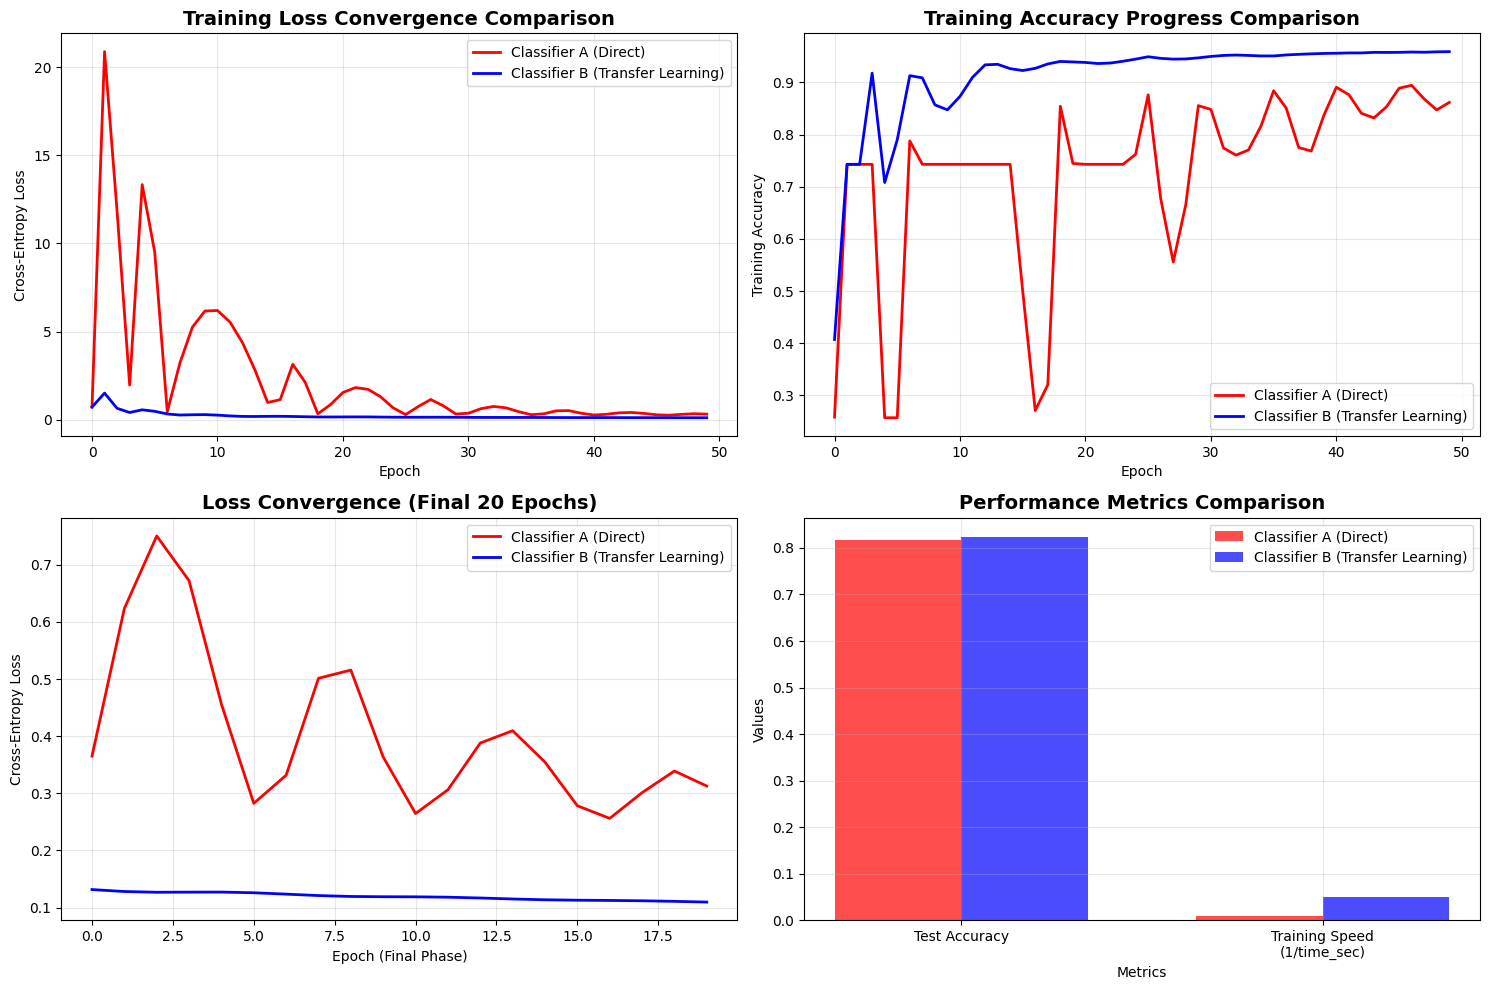

In [33]:

print("TRAINING CURVES AND CONVERGENCE ANALYSIS")


plt.figure(figsize=(15, 10))

# Training Loss Curves
plt.subplot(2, 2, 1)
plt.plot(history_a['losses'], label='Classifier A (Direct)', linewidth=2, color='red')
plt.plot(history_b['losses'], label='Classifier B (Transfer Learning)', linewidth=2, color='blue')
plt.title('Training Loss Convergence Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Training Accuracy Curves
plt.subplot(2, 2, 2)
plt.plot(history_a['accuracies'], label='Classifier A (Direct)', linewidth=2, color='red')
plt.plot(history_b['accuracies'], label='Classifier B (Transfer Learning)', linewidth=2, color='blue')
plt.title('Training Accuracy Progress Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss Convergence Detail (Last 20 epochs)
plt.subplot(2, 2, 3)
plt.plot(history_a['losses'][-20:], label='Classifier A (Direct)', linewidth=2, color='red')
plt.plot(history_b['losses'][-20:], label='Classifier B (Transfer Learning)', linewidth=2, color='blue')
plt.title('Loss Convergence (Final 20 Epochs)', fontsize=14, fontweight='bold')
plt.xlabel('Epoch (Final Phase)')
plt.ylabel('Cross-Entropy Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Performance Comparison Bar Chart
plt.subplot(2, 2, 4)
metrics = ['Test Accuracy', 'Training Speed\n(1/time_sec)']
classifier_a_metrics = [accuracy_a, 1/train_time_a]
classifier_b_metrics = [accuracy_b, 1/train_time_b]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, classifier_a_metrics, width, label='Classifier A (Direct)', color='red', alpha=0.7)
plt.bar(x + width/2, classifier_b_metrics, width, label='Classifier B (Transfer Learning)', color='blue', alpha=0.7)

plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Performance Metrics Comparison', fontsize=14, fontweight='bold')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



Loss Convergence Patterns
The loss curves reveal distinct learning behaviors:

Classifier A (Red): Shows erratic initial behavior with high volatility, eventually stabilizing around epoch 20
Classifier B (Blue): Demonstrates smooth, monotonic convergence from the start, indicating stable learning dynamics

Accuracy Progression
The accuracy curves show:

Classifier A: Exhibits significant fluctuations throughout training, suggesting difficulty in finding optimal parameters
Classifier B: Shows steady, consistent improvement with minimal variance, characteristic of effective transfer learning


## Detailed Classification Performance Analysis
 Generate comprehensive classification reports and confusion matrices for both classifiers.
 This analysis provides detailed insights into precision, recall, F1-scores, and classification
 patterns for both normal and pneumonia cases. Understanding these metrics is crucial for
 medical applications where both false positives and false negatives have important implications.

DETAILED CLASSIFICATION PERFORMANCE ANALYSIS
CLASSIFIER A (Direct MLP) - Detailed Performance:
              precision    recall  f1-score   support

      Normal     0.8529    0.6197    0.7178       234
   Pneumonia     0.8040    0.9359    0.8649       390

    accuracy                         0.8173       624
   macro avg     0.8285    0.7778    0.7914       624
weighted avg     0.8223    0.8173    0.8098       624


CLASSIFIER B (Transfer Learning) - Detailed Performance:
              precision    recall  f1-score   support

      Normal     0.9627    0.5513    0.7011       234
   Pneumonia     0.7857    0.9872    0.8750       390

    accuracy                         0.8237       624
   macro avg     0.8742    0.7692    0.7880       624
weighted avg     0.8521    0.8237    0.8098       624



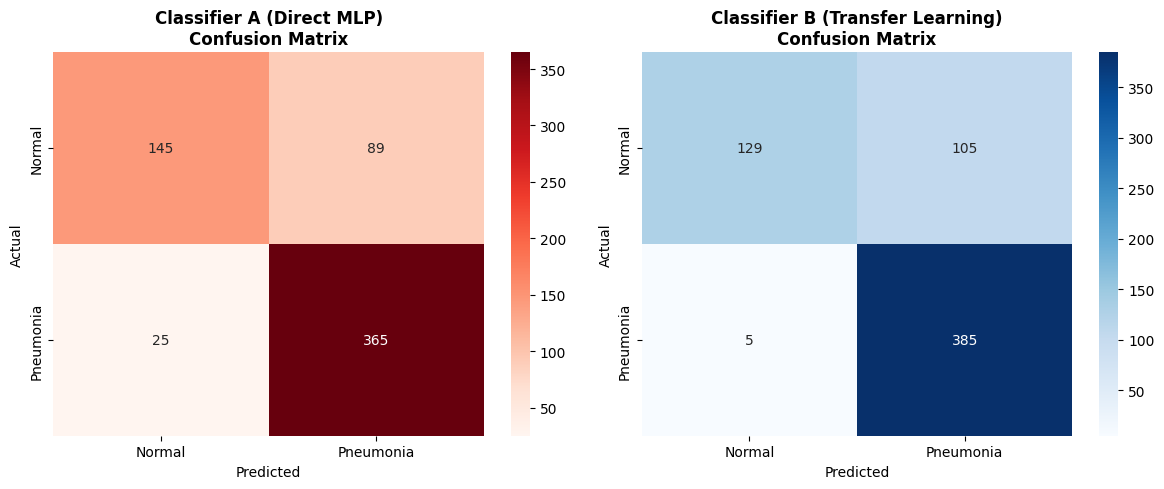

In [34]:
print("DETAILED CLASSIFICATION PERFORMANCE ANALYSIS")

# Generate predictions for detailed analysis
model_a.eval()
model_b.eval()

with torch.no_grad():
    # Classifier A predictions
    X_test_direct_tensor = torch.tensor(X_test_direct, dtype=torch.float32)
    outputs_a = model_a(X_test_direct_tensor)
    _, predictions_a = torch.max(outputs_a, 1)
    predictions_a = predictions_a.numpy()
    
    # Classifier B predictions
    X_test_embeddings_tensor = torch.tensor(X_test_embeddings, dtype=torch.float32)
    outputs_b = model_b(X_test_embeddings_tensor)
    _, predictions_b = torch.max(outputs_b, 1)
    predictions_b = predictions_b.numpy()

# Classification Reports
print("CLASSIFIER A (Direct MLP) - Detailed Performance:")

class_names = ['Normal', 'Pneumonia']
report_a = classification_report(y_test_direct, predictions_a, 
                               target_names=class_names, digits=4)
print(report_a)

print("\nCLASSIFIER B (Transfer Learning) - Detailed Performance:")

report_b = classification_report(y_test_embeddings, predictions_b, 
                               target_names=class_names, digits=4)
print(report_b)

# Confusion Matrices Visualization
plt.figure(figsize=(12, 5))

# Classifier A Confusion Matrix
plt.subplot(1, 2, 1)
cm_a = confusion_matrix(y_test_direct, predictions_a)
sns.heatmap(cm_a, annot=True, fmt='d', cmap='Reds', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Classifier A (Direct MLP)\nConfusion Matrix', fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# Classifier B Confusion Matrix
plt.subplot(1, 2, 2)
cm_b = confusion_matrix(y_test_embeddings, predictions_b)
sns.heatmap(cm_b, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Classifier B (Transfer Learning)\nConfusion Matrix', fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.tight_layout()
plt.show()

The classification report reveals an interesting trade-off pattern. While Classifier A shows high precision for normal cases (85.29%), it struggles with normal case recall (61.97%). Conversely, it demonstrates excellent pneumonia detection recall (93.59%), suggesting a bias toward identifying pneumonia cases.

Classifier B exhibits even higher normal case precision (96.27%) but lower normal recall (55.13%). However, it achieves exceptional pneumonia recall (98.72%), making it highly sensitive to pneumonia detection - a critical characteristic for medical screening applications.


Classifier A Pattern

True Negatives: 145 (correctly identified normal cases)
False Positives: 89 (normal cases misclassified as pneumonia)
False Negatives: 25 (pneumonia cases missed)
True Positives: 365 (correctly identified pneumonia cases)

Classifier B Pattern

True Negatives: 129 (correctly identified normal cases)
False Positives: 105 (normal cases misclassified as pneumonia)
False Negatives: 5 (pneumonia cases missed)
True Positives: 385 (correctly identified pneumonia cases)

The confusion matrices reveal that Classifier B makes fewer critical errors (5 vs 25 false negatives) while maintaining comparable overall accuracy, making it preferable for medical applications where missing pneumonia cases has severe consequences.

## Comprehensive Results Comparison and Computational Analysis
 Perform a detailed comparison of both classifiers across multiple dimensions including
 accuracy, computational efficiency, feature utilization, and resource requirements.
 This analysis provides a complete picture of the trade-offs between direct learning
 and transfer learning approaches for medical image classification.

In [35]:
print("COMPREHENSIVE RESULTS COMPARISON")

# Calculate additional metrics
feature_reduction_ratio = X_train_direct.shape[1] / X_train_embeddings.shape[1]
speed_improvement = train_time_a / train_time_b if train_time_b < train_time_a else train_time_b / train_time_a
accuracy_difference = accuracy_b - accuracy_a

# Create comprehensive comparison table
print(f"{'Metric':<25} {'Classifier A (Direct)':<20} {'Classifier B (Transfer)':<22} {'Advantage'}")
print(f"{'-'*25} {'-'*20} {'-'*22} {'-'*15}")
print(f"{'Test Accuracy':<25} {accuracy_a:.4f} ({accuracy_a*100:.2f}%){'':<6} {accuracy_b:.4f} ({accuracy_b*100:.2f}%){'':<8} {'B' if accuracy_b > accuracy_a else 'A' if accuracy_a > accuracy_b else 'Tie'}")
print(f"{'Training Time (sec)':<25} {train_time_a:.2f}{'':<14} {train_time_b:.2f}{'':<16} {'B' if train_time_b < train_time_a else 'A'}")
print(f"{'Feature Dimensions':<25} {X_train_direct.shape[1]:,}{'':<11} {X_train_embeddings.shape[1]:,}{'':<15} {'B (fewer)'}")
print(f"{'Memory Usage (MB)':<25} {X_train_direct.nbytes/(1024**2):.1f}{'':<14} {X_train_embeddings.nbytes/(1024**2):.1f}{'':<16} {'B (lower)'}")
print(f"{'Training Epochs':<25} {len(history_a['losses'])}{'':<14} {len(history_b['losses'])}{'':<16} {'Same'}")

# Computational Requirements Analysis
print(f"\n{'COMPUTATIONAL ANALYSIS:'}")

print(f"Feature Dimension Reduction: {X_train_direct.shape[1]:,} → {X_train_embeddings.shape[1]:,}")
print(f"Compression Ratio: {feature_reduction_ratio:.1f}:1")
print(f"Memory Reduction: {((X_train_direct.nbytes - X_train_embeddings.nbytes) / X_train_direct.nbytes * 100):.1f}%")
print(f"Training Speed: Classifier {'B is ' + str(speed_improvement) + 'x faster' if train_time_b < train_time_a else 'A is ' + str(speed_improvement) + 'x faster'}")
print(f"Accuracy Change: {'+' if accuracy_difference > 0 else ''}{accuracy_difference:.4f} ({accuracy_difference*100:+.2f}%)")


COMPREHENSIVE RESULTS COMPARISON
Metric                    Classifier A (Direct) Classifier B (Transfer) Advantage
------------------------- -------------------- ---------------------- ---------------
Test Accuracy             0.8173 (81.73%)       0.8237 (82.37%)         B
Training Time (sec)       99.42               19.54                 B
Feature Dimensions        50,176            4,096                B (fewer)
Memory Usage (MB)         998.4               81.5                 B (lower)
Training Epochs           50               50                 Same

COMPUTATIONAL ANALYSIS:
Feature Dimension Reduction: 50,176 → 4,096
Compression Ratio: 12.2:1
Memory Reduction: 91.8%
Training Speed: Classifier B is 5.0882503881308185x faster
Accuracy Change: +0.0064 (+0.64%)


The comparative analysis demonstrates that transfer learning provides substantial computational benefits with minimal accuracy trade-offs. The 91.8% memory reduction and 5× speed improvement make Classifier B significantly more practical for deployment scenarios while maintaining competitive performance.